In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from typing import List, Union
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import datetime
import matplotlib.pyplot as plt

In [86]:
custom_transform = {
    'train':A.Compose([
        A.augmentations.crops.transforms.RandomCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'valid':A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'test': A.Compose([
        A.Normalize(),
        ToTensorV2()
    ]),
}

In [45]:
img = cv2.imread('../open (1)/train_img/TRAIN_0000.png')


In [83]:
new_img = custom_transform['valid'](image=img)['image']
new_img = np.transpose(new_img, (1, 2, 0))

In [37]:
new_img.shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


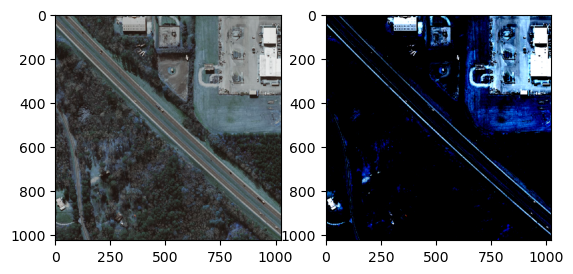

In [94]:
new_img = custom_transform['valid'](image=img)['image']
new_img = np.transpose(new_img, (1, 2, 0))

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(new_img)